In [1]:
import os
import numpy as np
from PIL import Image
from skimage.registration import optical_flow_ilk
from scipy.ndimage import fourier_shift
from skimage.exposure import match_histograms
from skimage.transform import warp
import cv2
import pywt

## 1. Setup and Imports

# RHM Resolution Enhancement via Depth-Guided Super-Resolution

This notebook demonstrates how to enhance the resolution of Reference Height Maps (RHM) using monocular depth estimation from aerial orthophotography.

## Approach Overview

1. **Load Data**: Aerial orthophotography, depth estimates, and low-resolution RHM
2. **Coregister**: Align RHM to the aerial image coordinate system (aerial defines ground truth location)
3. **Calibrate**: Scale/offset matching between depth and RHM
4. **Super-Resolve**: Wavelet fusion to combine RHM low-frequency structure with depth high-frequency details

The output is a high-resolution height map that preserves the accurate coarse structure from the RHM while adding fine details from the depth estimation.

In [2]:
depth_dir=r'depth_out'
img_dir=r'img_in'
rhm_dir=r'rhm_reference'

**Expected inputs**:
- `img_in/`: Aerial orthophotography chips (512x512 RGB)
- `depth_out/`: Depth maps generated by `infer_depth.py` using MiDaS or ZoeDepth models
- `rhm_reference/`: Low-resolution RHM ground truth (TIF format)

**About the depth maps**: The depth estimates are generated from the aerial orthophotography using monocular depth estimation models (see `infer_depth.py`). These provide high-resolution relative depth/height information but may have scale ambiguity and lack absolute accuracy. The RHM provides accurate absolute height information but at lower resolution. By fusing them, we get the best of both worlds.

## 2. Load Data

Load the aerial orthophotography, depth estimates, and low-resolution RHM ground truth.

Aerial Orthophotography (RGB)


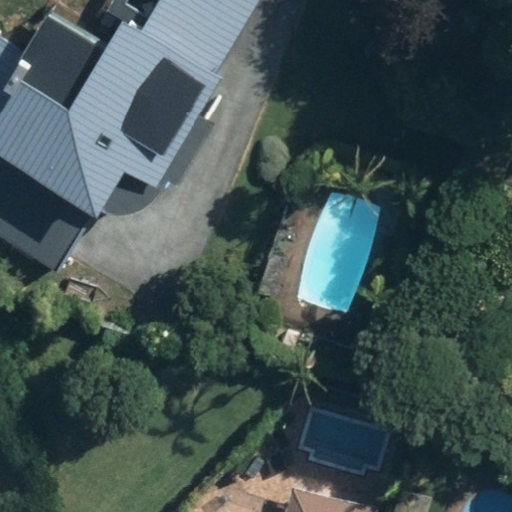


Estimated Height from Depth Model


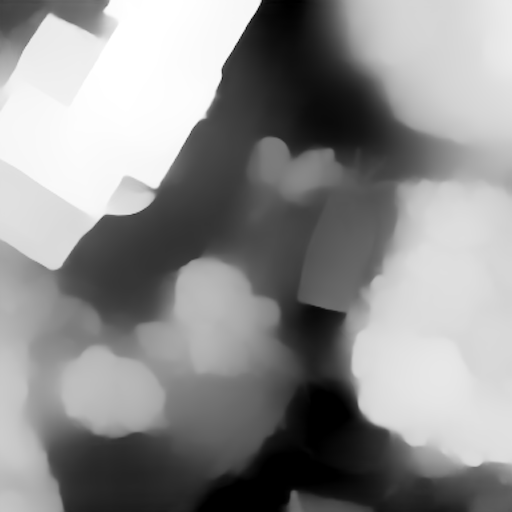


Reference Height Map (RHM) - Low Resolution Ground Truth


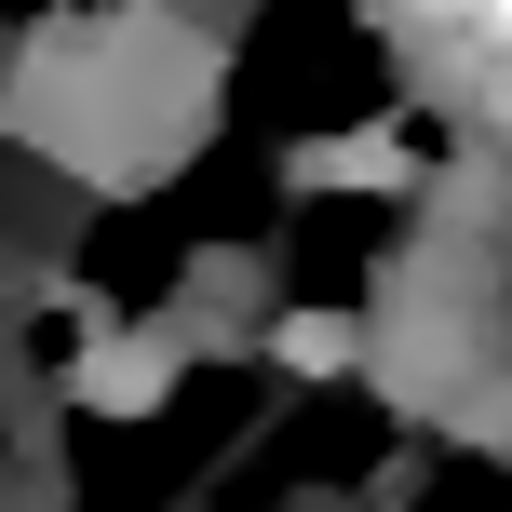

In [3]:
# File paths for this example
imfile = os.path.join(img_dir, '000000014021.png')
depthfile = os.path.join(depth_dir, '000000014021.png')
rhmfile = os.path.join(rhm_dir, '000000014021.tif')

# RHM scaling parameters
rhm_scale = 0.075 / 1.0  # 7.5cm / 1m - simulates low-resolution ground truth
dim = 512  # target resolution

# Load images
im = Image.open(imfile)  # Aerial orthophotography
depth = Image.open(depthfile)  # Depth estimate from infer_depth.py
rhm = Image.open(rhmfile)  # Low-resolution RHM ground truth

# Resample RHM to simulate low-resolution then upscale to target resolution
rhm = rhm.resize((int(dim * rhm_scale), int(dim * rhm_scale)))
rhm = rhm.resize((dim, dim), resample=Image.BICUBIC)

# Convert to float arrays and normalize to 0-255 range
deptha = np.array(depth).astype(np.float32)
rhma = np.array(rhm).astype(np.float32)

deptha /= np.max(deptha)
deptha = (1.0 - deptha) * 255.0  # Invert depth map

# Compute stats
mean_RHM, std_RHM = np.mean(rhm), np.std(rhm)

rhma /= np.max(rhma)
rhma *= 255.0

# Convert back to PIL for visualization
depth_img = Image.fromarray(deptha).convert("L")
rhm_img = Image.fromarray(rhma).convert("L")

print("Aerial Orthophotography (RGB)")
display(im)
print("\nEstimated Height from Depth Model")
display(depth_img)
print("\nReference Height Map (RHM) - Low Resolution Ground Truth")
display(rhm_img)

In [4]:
# Preprocessing: blur and edge detection for robust alignment

# Depth defines the reference coordinate system (from aerial image)
ref = cv2.GaussianBlur(deptha, (0, 0), 10.0)
# RHM is the moving image that needs to be aligned
mov = cv2.GaussianBlur(rhma, (0, 0), 10.0)

# Convert to 8-bit (0-255) for Canny edge detection
ref_8u = cv2.normalize(ref, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
mov_8u = cv2.normalize(mov, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Edge detection provides robust features for alignment
ref_edge = cv2.Canny(ref_8u, 50, 150)
mov_edge = cv2.Canny(mov_8u, 50, 150)

print("Preprocessed for alignment:")
print(f"  Reference (depth): {ref_8u.shape}")
print(f"  Moving (RHM): {mov_8u.shape}")

Preprocessed for alignment:
  Reference (depth): (512, 512)
  Moving (RHM): (512, 512)


## 3. Coregistration

The aerial orthophotography defines the ground truth spatial location. We need to align the RHM to match the aerial image coordinate system.

**Why coregistration is needed**: The depth estimates and RHM may have spatial misalignment due to:
- Different acquisition methods
- Georeferencing errors
- Processing artifacts

**Approach**: We use Enhanced Correlation Coefficient (ECC) affine registration:
1. Apply Gaussian blur to reduce noise
2. Detect edges using Canny (robust features for alignment)
3. Compute affine transformation that aligns RHM to depth
4. Apply transformation to warp RHM into aerial image coordinates

In [5]:
# Compute affine transformation using Enhanced Correlation Coefficient (ECC)
warp_mode = cv2.MOTION_AFFINE
warp_matrix = np.eye(2, 3, dtype=np.float32)  # Initialize as identity
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 200, 1e-6)

# Find transformation that aligns RHM (moving) to depth (reference)
cc, warp_matrix = cv2.findTransformECC(
    ref_8u.astype(np.float32),  # Reference: depth from aerial image
    mov_8u.astype(np.float32),  # Moving: RHM to be aligned
    warp_matrix, 
    warp_mode, 
    criteria
)

print(f"ECC correlation coefficient: {cc:.4f}")
print(f"Affine transformation matrix:\n{warp_matrix}")

# Apply transformation to align RHM to aerial image coordinates
# Note: We warp the original (non-blurred) RHM for best quality
rhm_aligned = cv2.warpAffine(
    rhma,  # Original RHM data
    warp_matrix,  # Transformation computed from edge-based registration
    (ref.shape[1], ref.shape[0]),  # Output size matches reference
    flags=cv2.INTER_LINEAR
)

print(f"\nAligned RHM shape: {rhm_aligned.shape}")

# Save aligned RHM for inspection
cv2.imwrite("rhm_aligned.png", rhm_aligned.astype(np.uint8))
print("Saved aligned RHM to rhm_aligned.png")

ECC correlation coefficient: 0.8010
Affine transformation matrix:
[[ 9.7191286e-01  2.8772134e-05  1.8541309e+01]
 [ 4.4977227e-03  1.0172637e+00 -2.5410059e+01]]

Aligned RHM shape: (512, 512)
Saved aligned RHM to rhm_aligned.png


RHM aligned to aerial image coordinates:


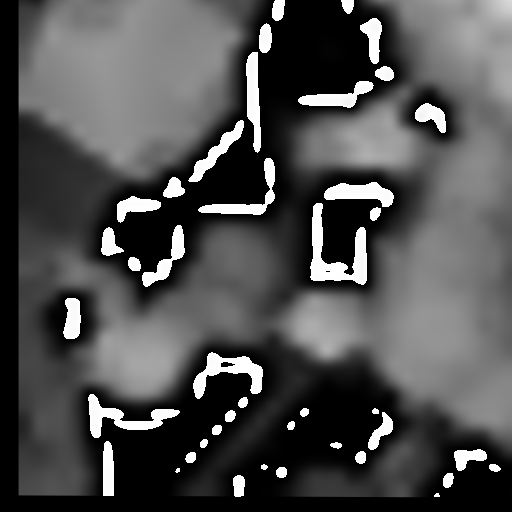

In [6]:
# Visualize the aligned RHM
rhm_aligned_img = Image.fromarray(rhm_aligned.astype(np.uint8))
print("RHM aligned to aerial image coordinates:")
display(rhm_aligned_img)

In [7]:
np.min(rhm_aligned), np.max(rhm_aligned)

(np.float32(-14.27453), np.float32(218.38425))

Intensity calibration: depth' = 0.5546 * depth + 1.6525

Wavelet fusion parameters:
  Wavelet: db2
  Levels: 7
  Alpha (low-freq blend): 0.0
  Gain (high-freq amplification): 1.0

Fusion complete!
Output shape: (512, 512)
Output range: [-0.25, 7.68]

Super-resolved RHM (RHM structure + depth details):


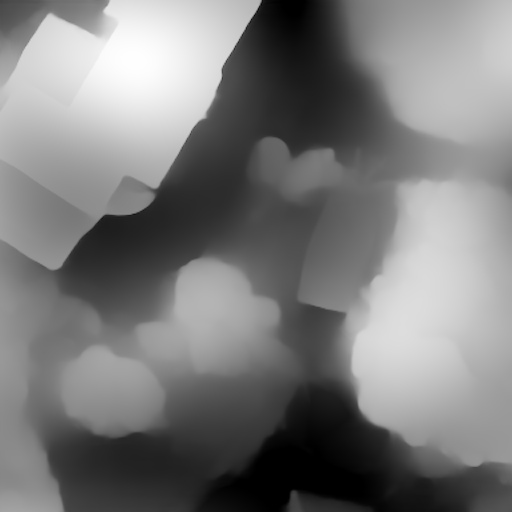

In [12]:
# Prepare inputs for fusion
# RHM: aligned ground truth (already in 0-255 range)
rhm_for_fusion = rhm_aligned.copy()

# Depth: reload and normalize to match RHM intensity range
depth_raw = np.array(Image.open(depthfile)).astype(np.float32)
depth_for_fusion = depth_raw / np.max(depth_raw)
depth_for_fusion = (1.0 - depth_for_fusion) * 255.0

#Get our distributions as expected
depth_for_fusion = (depth_for_fusion - np.mean(depth_for_fusion)) / np.std(depth_for_fusion) * std_RHM + mean_RHM
rhm_for_fusion = (rhm_for_fusion - np.mean(rhm_for_fusion)) / np.std(rhm_for_fusion) * std_RHM + mean_RHM

# Create mask for valid pixels
mask = np.isfinite(rhm_for_fusion) & np.isfinite(depth_for_fusion)

# Intensity calibration: scale/offset matching (linear regression)
# This ensures depth and RHM are in similar intensity ranges
a = np.cov(depth_for_fusion[mask], rhm_for_fusion[mask])[0, 1] / (np.var(depth_for_fusion[mask]) + 1e-9)
b = rhm_for_fusion[mask].mean() - a * depth_for_fusion[mask].mean()
depth_calibrated = a * depth_for_fusion + b

print(f"Intensity calibration: depth' = {a:.4f} * depth + {b:.4f}")

# Fill NaNs for wavelet transform (will be restored later)
rhm_filled = np.nan_to_num(rhm_for_fusion, nan=float(np.nanmean(rhm_for_fusion[mask])))
depth_filled = np.nan_to_num(depth_calibrated, nan=float(np.nanmean(depth_calibrated[mask])))

# Wavelet fusion parameters
wavelet = "db2"  # Daubechies 2 wavelet
level = 7  # Decomposition levels
alpha = 0.0  # 0 = use RHM low-freq (ground truth), 1 = use depth low-freq
gain = 1.0  # Amplification factor for depth high-freq details

print(f"\nWavelet fusion parameters:")
print(f"  Wavelet: {wavelet}")
print(f"  Levels: {level}")
print(f"  Alpha (low-freq blend): {alpha}")
print(f"  Gain (high-freq amplification): {gain}")


def fuse_swt2(rhm_arr, depth_arr, wavelet, level, alpha, gain):
    """
    Fuse RHM and depth using Stationary Wavelet Transform.
    
    Parameters:
    - rhm_arr: Reference height map (ground truth low-freq)
    - depth_arr: Depth estimate (high-freq details)
    - wavelet: Wavelet type
    - level: Decomposition levels
    - alpha: Low-freq blend (0=all RHM, 1=all depth)
    - gain: High-freq amplification factor
    
    Returns:
    - Fused image with RHM structure + depth details
    """
    # Decompose both images
    cr = pywt.swt2(rhm_arr, wavelet=wavelet, level=level)
    cd = pywt.swt2(depth_arr, wavelet=wavelet, level=level)
    
    # Handle different pywt output formats
    if isinstance(cr, list):
        # Format: [(cA_L, (cH_L, cV_L, cD_L)), ..., (cA_1, (cH_1, cV_1, cD_1))]
        fused = []
        for (cA_r, (cHr, cVr, cDr)), (cA_d, (cHd, cVd, cDd)) in zip(cr, cd):
            # Low-freq: blend RHM and depth based on alpha
            cA = (1 - alpha) * cA_r + alpha * cA_d
            # High-freq: use depth details with gain
            fused.append((cA, (gain * cHd, gain * cVd, gain * cDd)))
        return pywt.iswt2(fused, wavelet=wavelet)
    else:
        # Format: (cA_top, [(cH_L, cV_L, cD_L), ..., (cH_1, cV_1, cD_1)])
        cA_rhm, details_rhm = cr
        cA_depth, details_depth = cd
        # Low-freq: blend
        cA = (1 - alpha) * cA_rhm + alpha * cA_depth
        # High-freq: use depth details with gain
        details = [(gain * cH, gain * cV, gain * cD) for (cH, cV, cD) in details_depth]
        return pywt.iswt2((cA, details), wavelet=wavelet)


# Perform fusion
fused = fuse_swt2(rhm_filled, depth_filled, wavelet, level, alpha, gain)

# Restore NaN mask
fused[~mask] = np.nan

print(f"\nFusion complete!")
print(f"Output shape: {fused.shape}")
print(f"Output range: [{np.nanmin(fused):.2f}, {np.nanmax(fused):.2f}]")

# Visualize result
fused_stretched=(fused/np.max(fused))*255.
fused_stretched[fused_stretched<0]=0
fused_img = Image.fromarray(np.nan_to_num(fused_stretched, nan=0).astype(np.uint8))
print("\nSuper-resolved RHM (RHM structure + depth details):")

display(fused_img)

## Summary

This notebook successfully demonstrates RHM resolution enhancement using depth-guided super-resolution:

1. ✓ **Loaded** aerial orthophotography, depth estimates, and low-res RHM
2. ✓ **Coregistered** RHM to aerial image coordinates (aerial defines ground truth location)
3. ✓ **Calibrated** depth intensities to match RHM scale
4. ✓ **Fused** using SWT wavelets to preserve RHM structure while adding depth details

**Key Result**: High-resolution height map that combines:
- Accurate coarse structure from RHM ground truth
- Fine-grained details from depth estimation

**Next Steps**:
- Experiment with `alpha` and `gain` parameters for different fusion styles
- Try different wavelets (`db2`, `haar`, `sym4`, etc.)
- Process multiple image chips in batch
- Quantitative validation against high-res ground truth if available

## 4. Wavelet-Based Super-Resolution

Now we fuse the aligned RHM with the depth estimate to create a high-resolution height map.

**Why wavelet fusion?**
- **Frequency separation**: Wavelets decompose images into low-frequency (coarse structure) and high-frequency (fine details) components
- **Selective fusion**: We can combine the best of both sources:
  - **Low frequency from RHM**: Accurate coarse structure (ground truth)
  - **High frequency from depth**: Fine details (high resolution)

**Stationary Wavelet Transform (SWT)**:
- Unlike standard DWT, SWT doesn't downsample, avoiding resolution loss
- Produces same-size outputs at each level
- Better for fusion tasks where preserving resolution is critical

**Key parameters**:
- `alpha`: Controls low-frequency blend (0 = all RHM, 1 = all depth)
- `gain`: Amplifies high-frequency details from depth
- `level`: Number of decomposition levels (more = coarser frequency bands)